# SiMFS-Tk Example: Focus functions
This example showcases SiMFS-Tk's builtin focus functions and how to evaluate them on a diffusion trajectory. 

### Components

- ``simfs_dif``
- ``simfs_exi``
- ``simfs_pre``

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from pysimfs import *

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


## Evaluating an excitation focus

In [2]:
with Simulation() as s:
    s.add(
        Diffusion(
            collision_output=os.devnull, 
            coordinate_output='coords', 
            experiment_time=20e-3
        )
    )
    s.add(
        Excitation(
            input='coords',
            output='exi.dat',
            power=10e-6,
            wavelength=488e-9
        )
    )
    log = s.run()
    res = s.get_results()

Folder ./pysimfs_data exists.
Started simulation with 2 component processes.
Simulation completed after 0.1 seconds.


### Inspecting the data

Pysimfs loads the generated data from the simulation files as ``numpy`` arrays with a preset data type.
Focus values are a typed array of ``(v, t)`` tuples.

In [3]:
excitation = res['exi.dat']
excitation

array([(1.31751024e+19, 0.00000e+00), (1.14629655e+19, 1.00000e-07),
       (9.33980820e+18, 2.00000e-07), ..., (5.34747271e+11, 1.99997e-02),
       (4.45150576e+11, 1.99998e-02), (5.13890010e+11, 1.99999e-02)],
      dtype=[('v', '<f8'), ('t', '<f8')])

Plotting the photon flux density $\Phi$ vs time shows a the fluctuating pattern of laser intensity that *"hits"* the molecule during the expriment.

Text(0.5, 0, 'Time in ms')

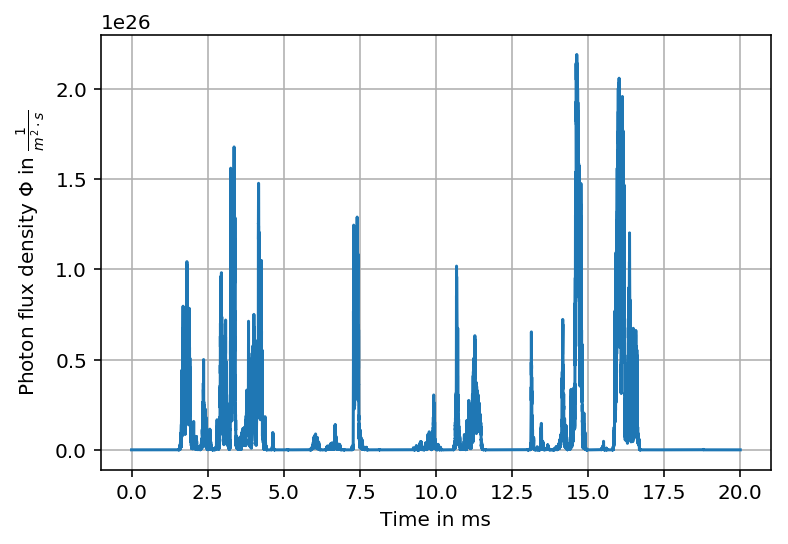

In [4]:
fig = plt.figure()
plt.plot(excitation['t']*1e+3, excitation['v'])
plt.grid()
plt.ylabel(r'Photon flux density $\Phi$ in $\frac{1}{m^2 \cdot s}$')
plt.xlabel('Time in ms')

## Focus shapes

The photon flux density is calculated according to:

$$\Phi = \frac{P  \lambda}{\rm h \rm c} \cdot F(x, y, z)$$

where $P$ is the laser power, $\lambda$ the wavelength and $\rm h$ and $\rm c$ Planck's constant and the speed of light. $F(x,y,z)$ describes the focus shape. One approach to normalize $F$ is to require that for every value of $z$: $\iint_{-\infty}^\infty  \text{dx dy} = 1$, i.e. every xy-slice along z needs to have unit area. Intuitively, every excitation photon (all the energy) has to pass every plane along z at some point.

There are severel builtin focus shapes $F(x, y, z)$ for this purpose, that partially or completely fulfill this constraint.

1. Gauss (only in z=0)
   $$F_\text{Gauss} = \frac{1}{\frac{\pi}{2} w_x w_y} \cdot e^{2\frac{x^2}{w_x^2}} \cdot e^{2\frac{y^2}{w_y^2}} \cdot e^{2\frac{z^2}{w_z^2}}$$
   
2. Gauss with z-modulated xy-waist
   $$F_\text{GaussMod} = $$
   
   ... TODO
   
### Using focus shapes

To use focus shape with ``simfs_exi`` you set the ``type`` parameter to one of

- ``3dGauss``
- ``XYGaussZExp``
- ``gaussBeam``
- ``eField``
- ``grid``

To configure the shape paramters, set them in the toplevel ``shape`` paramter. For example, to  use the modulated Gaussian with different focus waists we get the default parameters for the ``XYGaussZExp`` type:

In [5]:
shape = Excitation(type='XYGaussZExp').all_params['shape']
shape

{'waist_xy': 2.49e-07, 'waist_z': 6.37e-07}

And reset the parameters that we are interested in:

In [6]:
shape['waist_xy'] = 230e-9
shape['waist_z'] = 590e-9
shape

{'waist_xy': 2.3e-07, 'waist_z': 5.9e-07}

Now you can run a simulation with the parametrized focus function:

In [7]:
with Simulation() as s:
    s.add(
        Diffusion(
            collision_output=os.devnull, 
            coordinate_output='coords', 
            experiment_time=20e-3
        )
    )
    s.add(
        Excitation(
            input='coords',
            output='exi.dat',
            type='XYGaussZExp',
            shape=shape,
            power=10e-6,
            wavelength=488e-9
        )
    )
    log = s.run()
    res = s.get_results()

Folder ./pysimfs_data exists.
Started simulation with 2 component processes.
Simulation completed after 0.12 seconds.


## Precalculating shapes

Sometimes it is desirable to get a full picture of your focus shape. In some cases (like the ``eField`` shape) it is the only way to efficiently use it in a simulation since it is expensive to calculate online. For these cases, there is ``simfs_pre``. It evaluates a focus function on a grid and saves the data to a file. It is a special component, in that it is not used in a pipeline context, but prior to a simulation run to build a lookup file for the ``grid`` focus shape.

In [8]:
Precalculate(type='eField', shape={'theta':{'n':10}, 'phi': {'n': 10}}).params

{'type': 'eField', 'shape': {'theta': {'n': 10}, 'phi': {'n': 10}}}

In [9]:
grid = {
    'x': {'max': 1e-06, 'min': -1e-06, 'n': 101},
    'y': {'max': 1e-06, 'min': -1e-06, 'n': 101},
    'z': {'max': 1.5e-06, 'min': -1.5e-06, 'n': 101}
}

types =  ('3dGauss', 'XYGaussZExp', 'gaussBeam')

for t in types:
    with Simulation() as S:
        S.add(Precalculate(type=t, filename=f'{t}.dat', grid=grid))
        S.run()
        
with Simulation() as S:
    S.add(
        Precalculate(
            type='eField', 
            filename=f'eField.dat', 
            grid=grid, 
            shape={
                'theta': {'n':10},  # reduce the accuracy to save time 
                'phi': {'n': 10}
            }
        )
    )
    log = S.run()
        

Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 1.11 seconds.
Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 1.09 seconds.
Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 1.1 seconds.
Folder ./pysimfs_data exists.
Started simulation with 1 component processes.
Simulation completed after 3.15 seconds.


In [10]:
gauss  = utils.PrecalculatedGridData('3dGauss.dat',     dtype='f8')
exp    = utils.PrecalculatedGridData('XYGaussZExp.dat', dtype='f8')
gbeam  = utils.PrecalculatedGridData('gaussBeam.dat',   dtype='f8')
efield  = utils.PrecalculatedGridData('eField.dat',   dtype='f8')

We can take a look at the shapes now. Note that the ``GridData`` class has some helpers ``_ix``, ``_iy`` and ``_iz`` that compute the grid index for a given real-space position in m. The expression ``img.data[:,img._iy(0),:].T`` is the xz-plane at y=0. 

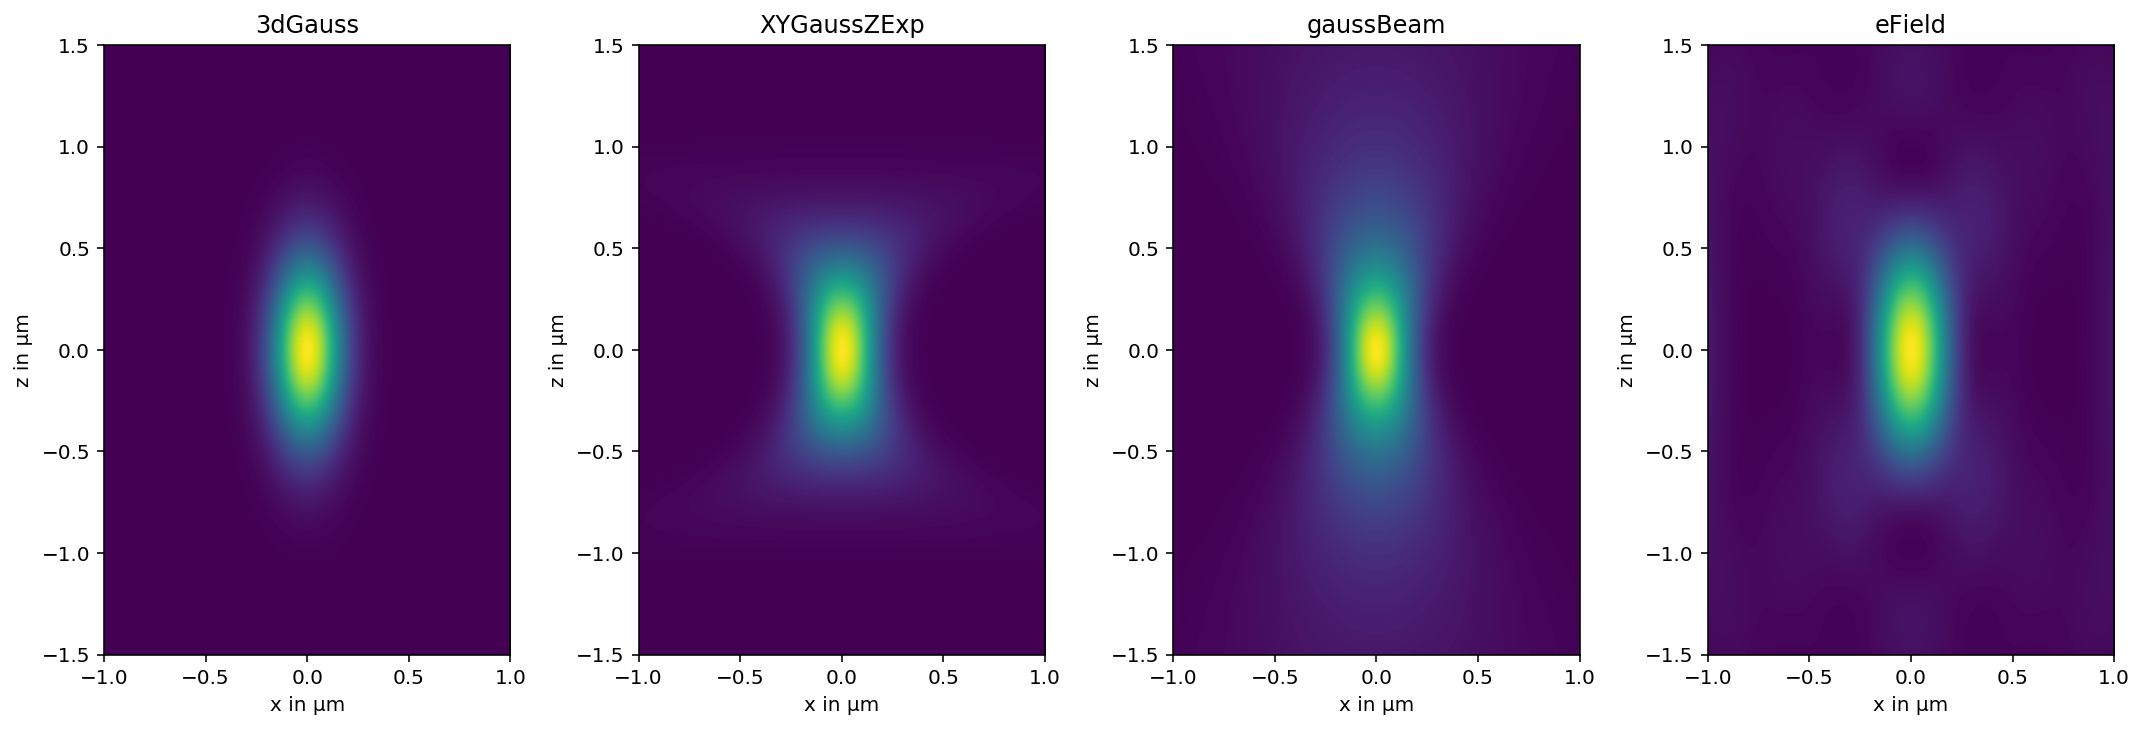

In [11]:
fig, axes = plt.subplots(ncols=4, figsize=(15,10))

for img, ax, title in zip((gauss, exp, gbeam, efield), axes, list(types)+['eField']):
    ax.imshow(img.data[:,img._iy(0),:].T, extent=(-1, 1, -1.5, 1.5), interpolation='bicubic')
    ax.set_title(title)
    ax.set_xlabel('x in µm')
    ax.set_ylabel('z in µm')
    
plt.tight_layout()

## Interpolating a focus shape

You may have noticed that the E-field shape is expensive to compute. To use it in a simulation we *have* to precalculate it.
Once we spent the time generating a grid with sufficient resolution, we can use it with ``simfs_exi`` or ``simfs_det`` by setting the ``grid`` shape:

In [12]:
with Simulation() as s:
    s.add(
        Diffusion(
            collision_output=os.devnull, 
            coordinate_output='coords', 
            experiment_time=20e-3
        )
    )
    s.add(
        Excitation(
            input='coords',
            output='exi.dat',
            type='grid',
            shape={
                'file': 'eField.dat',
                'interpolation': 'nearest' # or linear
            },
            power=10e-6,
            wavelength=488e-9
        )
    )
    log = s.run()
    res = s.get_results()

Folder ./pysimfs_data exists.
Started simulation with 2 component processes.
Simulation completed after 0.14 seconds.


In this way the grid shape can be used to load external focus shapes from disk. Check the ``simfs_pre`` documentation for details on the required file format.